# Clustering of centroids, comparison of different methods

## Code

In [2]:
import sys
sys.path.append('../src/data')
from download_pois_networks import download_POIs
from download_pois_networks import download_street_network, networks_to_gdf, analyze_street_network

In [36]:
import re
from sklearn.cluster import KMeans
import logging
from h3 import h3
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import math

EQUAL_AREA_PROJ = '+proj=cea'
LON_LAT_PROJ = 'EPSG:4326'
MERCATOR_PROJ = 'epsg:3395'

def get_raw_data_path():
    """Function to get path for raw data. Allows to retrieve correct path when calling from another script.

    Returns:
        str: path for raw data
    """
    main_path = os.getcwd().split("15_min/")[0]+"15_min"
    raw_data_path = os.path.join(main_path, "data/raw/")    
    return raw_data_path

def create_hexagonal_grid(place_name, boundary, resolution=8, crs=LON_LAT_PROJ):
    """Create hexagonal grid inside boundary.

    Args:
        boundary (GeoDataFrame): boundary polygon
        resolution (int, optional): resolution of tessellation. Defaults to 8.

    Returns:
        GeoDataFrame: geodf of hexagons
    """
    # --------------- Check file existence ------------------------

    # Get raw data path
    raw_data_path = get_raw_data_path()
    re_place_name = re.sub(r'[\s\W]+', '', place_name)
    
    # Define file path for the hexagonal grid
    file_path_hex_grid = f"{raw_data_path}{re_place_name}_r{resolution}_hex_grid.pkl"
    
    # Check if the hexagonal grid file exists
    if os.path.exists(file_path_hex_grid):
        logging.info(f"Loading existing hexagonal grid for {place_name} at resolution {resolution}")
        with open(file_path_hex_grid, 'rb') as f:
            gdf_hex = pickle.load(f)
        return gdf_hex

    # ---------------- Compute grid ------------------------------

    logging.info(f"Creating new hexagonal grid for {place_name} at resolution {resolution}")

    # Store initial CRS
    original_crs = boundary.crs
    boundary_ = boundary.copy()

    # Reproject the polygon into equal area CRS
    boundary_ = boundary_.to_crs(crs) 

    # Get boundary polygon coordinates
    boundary_shape = boundary_.geometry.iloc[0]
    
    # Get hexagons that intersect with the boundary
    hex_ids = list(h3.polyfill(
        boundary_shape.__geo_interface__,
        resolution
    ))
    
    # Convert hexagons to polygons
    hex_polygons = []
    for hex_id in hex_ids:
        polygon_coords = h3.h3_to_geo_boundary(hex_id)
        polygon = Polygon(polygon_coords)
        hex_polygons.append({
            'geometry': polygon,
            'hex_id': hex_id
        })
    
    # Convert to GeoDataFrame
    gdf_hex = gpd.GeoDataFrame(hex_polygons, crs=crs)
    gdf_hex.to_crs(original_crs)

    # Save the hexagonal grid
    with open(file_path_hex_grid, 'wb') as f:
        pickle.dump(gdf_hex, f)
    logging.info(f"Saved hexagonal grid for {place_name} at resolution {resolution}")

    return gdf_hex

def KMeans_clustering(centroids,n_clusters=10):
    """Perform KMeans clustering to obtain batches of close-by centroids.

    Args:
        centroids (Series): centroids of the hexagonal grid.
        batch_size (int, optional): number of clusters. Defaults to 10.

    Returns:
        list<Series>, list<list>: Lists of centroids in batches and their center.
    """
    # Extract x and y coordinates
    coords = centroids.apply(lambda c: [c.x, c.y])
    coords = coords.tolist()

    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto').fit(coords)
    labels = kmeans.labels_
    means = kmeans.cluster_centers_

    # Create a list of subseries based on clustering labels
    subseries = []
    for i in range(n_clusters):
        # Get indices where label equals the current cluster
        cluster_indices = np.where(labels == i)[0]
        # Create subseries using the original centroids Series
        subseries.append(centroids.iloc[cluster_indices])
    
    return subseries, means

def grid_clustering(centroids, n_clusters=12):
    """Perform grid-based clustering to obtain batches of close-by centroids.
    Clusters are created using a grid of equal-sized square cells.

    Args:
        centroids (Series): centroids of the hexagonal grid.
        n_clusters (int, optional): approximate number of clusters to create. Defaults to 10.

    Returns:
        list<Series>, list<list>: Lists of centroids in batches and their center.
    """
    
    # Extract x and y coordinates
    coords = centroids.apply(lambda c: [c.x, c.y])
    coords = np.array(coords.tolist())
    
    # Find min and max coordinates to determine grid boundaries
    min_x, min_y = np.min(coords, axis=0)
    max_x, max_y = np.max(coords, axis=0)
    
    # Calculate the range in both dimensions
    range_x = max_x - min_x
    range_y = max_y - min_y
    
    # Determine cell size
    cell_size = math.sqrt(range_x*range_y/n_clusters) #max(range_x, range_y) / math.sqrt(n_clusters)
    
    # Calculate number of cells in each dimension
    num_cells_x = math.ceil(range_x / cell_size)
    num_cells_y = math.ceil(range_y / cell_size)
    
    # Initialize structures
    subseries = []
    means = []
    
    # Create the grid with square cells
    for i in range(num_cells_x):
        for j in range(num_cells_y):
            # Calculate cell boundaries
            cell_min_x = min_x + i * cell_size
            cell_max_x = min_x + (i + 1) * cell_size
            cell_min_y = min_y + j * cell_size
            cell_max_y = min_y + (j + 1) * cell_size
            
            # Find points in this cell
            indices = []
            for idx, point in enumerate(coords):
                if (cell_min_x <= point[0] < cell_max_x and 
                    cell_min_y <= point[1] < cell_max_y):
                    indices.append(idx)
            
            # Only add non-empty cells
            if indices:
                # Create subseries using the original centroids Series
                subseries.append(centroids.iloc[indices])
                
                # Calculate center of the cell
                center_x = (cell_min_x + cell_max_x) / 2
                center_y = (cell_min_y + cell_max_y) / 2
                means.append([center_x, center_y])
    
    return subseries, means

def plot_hex_clusters(centroids_batches, batch_means):
    """Plot clustering of centroids.

    Args:
        centroids_batches (list<Series>): _description_
        batch_means (list<list>): _description_
    """

    # Gdf clusters
    gdf_clusters = gpd.GeoDataFrame(columns=['geometry','idx'])
    gdf_clusters.set_crs(LON_LAT_PROJ)
    for idx,centroids_batch in enumerate(centroids_batches):
        gdf_temp = gpd.GeoDataFrame({'geometry':centroids_batch.values,'idx':[idx]*len(centroids_batch)})
        gdf_clusters = pd.concat([gdf_clusters, gdf_temp], ignore_index=True)
    gdf_clusters = gdf_clusters.to_crs(MERCATOR_PROJ)

    # Gdf means
    gdf_means = gpd.GeoSeries([Point(m[0], m[1]) for m in batch_means],crs=LON_LAT_PROJ)
    gdf_means = gdf_means.to_crs(MERCATOR_PROJ)

    # Plot
    _,ax = plt.subplots()
    #gdf_hex = gdf_hex.to_crs(MERCATOR_PROJ)
    #gdf_hex.plot(ax=ax)
    gdf_clusters.plot(column='idx',cmap='Reds',ax=ax)
    gdf_means.plot(ax=ax,color='k')
    #plt.savefig('../reports/figures/hexagons_clustering.pdf')
    plt.show()

    pass

In [37]:
# Set the two parameters
place_name = "Vienna, Austria"
tags={'shop':['supermarket']}
resolution=8

# Download POIs
boundary, pois = download_POIs(place_name=place_name, tags=tags)
logging.info("Downloaded POIs\n")

# Create hexagonal grid
gdf_hex = create_hexagonal_grid(place_name,boundary,resolution=resolution)

# Calculate centroids for all hexagons using equal_area_crs
gdf_centroids = gdf_hex.copy()
gdf_centroids.to_crs(EQUAL_AREA_PROJ)
centroids = gdf_centroids.geometry.centroid
centroids = centroids.to_crs(LON_LAT_PROJ)

INFO:root:Downloaded POIs

INFO:root:Loading existing hexagonal grid for Vienna, Austria at resolution 8


Total POIs: 2795
Found 1046 shop-supermarket


/tmp/ipykernel_7841/3770982548.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf_centroids.geometry.centroid


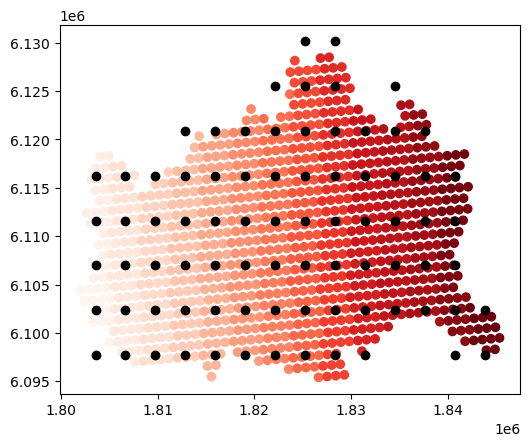

In [38]:
# Perform grid clustering
centroids_batches, batch_means = grid_clustering(centroids,n_clusters=100)
plot_hex_clusters(centroids_batches,batch_means)

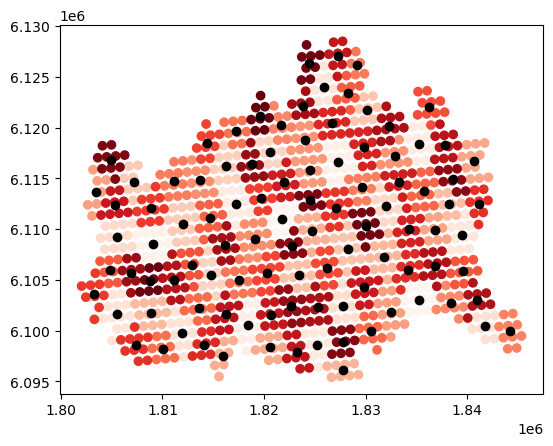

In [39]:
# Perform kmeans clustering
centroids_batches, batch_means = KMeans_clustering(centroids,n_clusters=100)
plot_hex_clusters(centroids_batches,batch_means)

In [40]:
gdf_hex.shape

(924, 2)

In [42]:
gdf_centroids.shape

(924, 2)

In [45]:
batches_lenghts = [len(centroids_batch) for centroids_batch in centroids_batches]
print(batches_lenghts)
print(np.sum(batches_lenghts))

[8, 10, 11, 12, 10, 10, 10, 9, 10, 8, 12, 10, 8, 9, 12, 9, 7, 9, 10, 13, 8, 8, 11, 9, 7, 11, 12, 8, 10, 7, 9, 11, 8, 7, 12, 10, 9, 8, 10, 13, 9, 8, 10, 9, 11, 5, 10, 8, 8, 9, 9, 11, 10, 8, 7, 9, 8, 10, 10, 11, 9, 8, 11, 9, 11, 10, 8, 9, 8, 10, 11, 10, 8, 9, 11, 9, 8, 8, 9, 9, 10, 11, 10, 8, 10, 10, 9, 7, 8, 9, 9, 8, 7, 9, 10, 6, 10, 8, 7, 8]
924


In [48]:
for centroids_batch in centroids_batches:
    if 54 in centroids_batch.index:
        print(centroids_batch)

54     POINT (16.53033 48.18492)
138    POINT (16.52653 48.19151)
158    POINT (16.52234 48.18441)
373    POINT (16.53451 48.19203)
511    POINT (16.51855 48.19100)
518    POINT (16.51436 48.18389)
526    POINT (16.51816 48.17730)
756    POINT (16.52614 48.17781)
813    POINT (16.53831 48.18544)
dtype: geometry


In [1]:
tuple([3,4])

(3, 4)

In [2]:
list((3,4))

[3, 4]